In [1]:
"""
Run this if to setup environment before anything else
"""
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib

# INF8215 - Intelligence artif.: méthodes et algorithmes 
## Automne 2020 - TP1 - Méthodes de recherche 
### Membres de l'équipe
    - Louis Sérey Larose - 1846124
    - Aladji Faye - 2035541
    - Nicolas Veber -2036057


## Directives de remise
Le travail sera réalisé en équipe de trois. Vous remettrez un fichier nommé TP1\_NomDuMembre1\_NomDuMembre2\_NomDuMembre3.ipynb dans la boite de remise de travaux sur moodle. 

Le fichier devra être remis avant le **29 septembre à 23h55**. Tout travail en retard sera pénalisé
de 10\% de points en moins par jour de retard.


## Snail Labyrinth

*Snail Labyrinth* est un jeu dont le but est de guider des escargots dans un labyrinthe jusqu'à leur sortie personnelle. La taille des labyrinthes varie. Chaque escargot peut se déplacer dans cinq directions: vers le haut, vers le bas, vers la droite, vers la gauche et rester sur place. 

A chaque étape, chaque escargot à la possibilité d'effectuer un mouvement.
Les escargots ne peuvent pas se déplacer dans une case où se déplace un autre escargot. De plus, les escargots laissent derrière ils une substance toxique et ne peuvent donc pas se déplacer dans une case qui a déjà été occupée par un autre escargot.

A titre d'illustation, les images ci-dessous donnent un exemple d'une configuration initiale (Figure 1) et d'une configuration où deux mouvements ont eté realisés (Figure 2). Les étapes sont les suivantes:

- Etape 1: le escargot A se déplace vers la droite et le escargot B vers la droite.
- Etape 2: le escargot A se déplace vers la droite et le escargot B vers la droite.

<table><tr>
<td> <img src="https://imgur.com/3W4iDSk.png" alt="Drawing"/> <figcaption>Figure 1 - Example d'une configuration initiale.</figcaption></td>
<td> <img src="https://imgur.com/3uaD3AO.png" alt="Drawing"/><figcaption>Figure 2 - Example de deux mouvements.</figcaption> </td>
</tr></table>

L'objectif de ce TP est d'écrire un programme qui permet aux escargots d'atteindre leur destination en un **minimum de mouvements**.

Pour ce faire, il vous est demandé de compléter les deux classes fournies en Python. Vous pouvez réimplémenter ces classes-là et faire le TP dans un autre langage si vous le désirez.

## 1. Représentation du problème (10pts)

Le problème est défini par les règles suivantes. Les colonnes sont numérotées de gauche à droite de 0 à $m$ et les lignes sont numérotées de haut en bas, de 0 à $n$. Un escargot est considérée *résolue* lorsqu'il arrive à sa propre sortie.

L'état du labyrinthe est représenté par un objet de la classe **State** qui contient les variables d'instance suivantes: 

- `pos`: vecteur indiquant la position de chaque escargot sur la grille;
- `venoms`: ensemble des positions du poison laissé par les escargots;
- `d`: liste indiquant la direction du déplacement de chaque escargot fait à partir de l'état précédent pour atteindre l'état courant (0: rester en place, 1: vers le haut, 2: vers la droite, 3: vers le bas et 4: vers la gauche);
- `prev`: l'état précédent



In [2]:
import numpy as np
import math
import copy

class Position:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, other):
        return math.fabs(other.x - self.x) + math.fabs(other.y - self.y)
        
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __repr__(self):
        return "(%d,%d)" % (self.x, self.y)
    
    def __str__(self):
        return "(%d,%d)" % (self.x, self.y)
    
    def __hash__(self):
        return int(self.x*1+self.y*2)

class State:
    
    """
    Contructeur d'un état initial
    """
    def __init__(self, pos):
        """
        pos donne la position du escargot i;
        """
        self.pos = np.array(copy.deepcopy(pos))
        """
        venoms garde les positions du poisons
        """
        self.venoms = set()
        
        """
        d et prev premettent de retracer l'état précédent et le dernier mouvement effectué
        """
        self.d = self.prev = None
        
        self.nb_moves = 0
        self.h = 0

    """
    Constructeur d'un état à partir mouvement (d)
    """
    def move(self, d):
        # TODO
        s = State(self.pos)
        s.d = d
        s.venoms = set(self.venoms)
        s.prev = self
        for i in range (len(d)):
            if (d[i]==1):
                s.venoms.add(self.pos[i])
                s.pos[i].x-=1
            elif (d[i]==2):
                s.venoms.add(self.pos[i])
                s.pos[i].y+=1
            elif (d[i]==3):
                s.venoms.add(self.pos[i])
                s.pos[i].x+=1
            elif (d[i]==4):
                s.venoms.add(self.pos[i])
                s.pos[i].y-=1
        s.nb_moves = s.prev.nb_moves + 1
                    
        return s
    
    def __eq__(self, other):
        if not isinstance(other, State):
            return NotImplemented
        if len(self.pos) != len(other.pos):
            print("les états n'ont pas le même nombre de limaces")

        return (len(self.venoms) == len(other.venoms) and np.array_equal(self.pos, other.pos) and self.venoms == other.venoms)
        
    def __hash__(self):
        h = 0
        for snail_position in self.pos:
            h += snail_position.x*25 + snail_position.y*30
        for venom_position in self.venoms:
            h += snail_position.x*25 + snail_position.y*30
        return int(h)
    
    def __lt__(self, other):
        return (self.nb_moves + self.h) < (other.nb_moves + other.h)

    def __repr__(self):
        out = ""
        for index, limace in enumerate(self.pos):
            out += "Escargot %d (%d,%d) | " % (index+1, limace.x, limace.y)
        return "State: " + out[:-3]
    
    def __str__(self):
        out = ""
        for index, limace in enumerate(self.pos):
            out += "Escargot %d (%d,%d) | " % (index+1, limace.x, limace.y)
        return out[:-3]
        

#### Implémentation 
   - Complétez la fonction ***move*** en déplaçant les escargots de 1 case dans la bonne direction (d[i]= 0, 1, 2, 3 ou 4). Nous supposons que le déplacement est possible lorsque la fonction est appelée. **Attention** : Cette fonction doit créer un nouvel objet *State* et définir les variables d'instance `prev`, `venoms` et `d`.
   
Vous pouvez tester votre code avec la fonction ***test1()*** dans la cellule suivante. Assurez-vous d'avoir déjà roulé la cellule avec la définition de la classe **State** avant. Vous devriez obtenir les résultats suivants:
```
True
(3,0)  (3,1)
True
True
```

In [3]:
def test1():
    b = True
    s0 = State([Position(0,0), Position(3,0)])
    s1 = s0.move([2,2])
    print(s1.prev == s0)
    b = b and s1.prev == s0
    print(s0.pos[1], " ", s1.pos[1])
    s1 = s1.move([0,0])
    print(s1 == s1.prev)
    b = b and s1 == s1.prev
    s1 = s1.move([3,3]).move([4,4]).move([1,1])
    
    s2 = s0.move([3,3]).move([2,2]).move([1,1]).move([0,0]).move([4,4])
    
    print(s1 == s2)
    b = b and s1 == s2
    print("\nrésultat correct" if b else "\nmauvais résultat")
test1()

True
(3,0)   (3,1)
True
True

résultat correct


## 2. Mouvements possibles (25pts)
Pour représenter le problème, nous allons utiliser la classe **Labyrinth** qui contient les champs suivants:

- `nb_lines`: le nombre de lignes de la grille;
- `nb_columns`: le nombre de colonnes de la grille;
- `exits`: un vecteur contenant la position de la sortie de chaque escargot (escargot $i$ sort à la sortie `exits[i]`);
- `walls`: un vecteur contenant la position de chaque murs dan la grille;
- `free_pos`: une matrice $n\times m$ contenant une valeur booléenne permettant de savoir si la case est libre ou non.

Toutes les informations pour un escargot se trouve au même indice $i$ dans chacun des vecteurs.

In [12]:
from collections import deque
import heapq
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import itertools

class Labyrinth:
    
    def __init__(self, lines, columns ,exits, walls):
        self.nb_lines = lines
        self.nb_columns = columns
        self.exits = exits
        self.walls = walls
        self.free_pos = None

    """ est il final? """
    def success(self, state):
        a = True
        i = 0
        while i < (len(self.exits)) and a:
            if (self.exits[i] != state.pos[i]):
                a = False
            i+=1    
            
        return a

    def init_positions(self, state):
        self.free_pos = np.ones((self.nb_lines, self.nb_columns), dtype=bool)
        for i in range(len(state.pos)):
            self.free_pos[state.pos[i].x,state.pos[i].y]=0
            
        for i in range(len(self.walls)):
            self.free_pos[self.walls[i].x,self.walls[i].y]=0
        
        for venom in (state.venoms):
            self.free_pos[venom.x,venom.y]=0
        
    
    def possible_moves_snail(self, snail_position, exit_position, other_exits):
        moves = [(0,snail_position)]
        x = snail_position.x
        y = snail_position.y
        
        other_exits_copy = [other_exits[i] for i in range(len(other_exits))]
        
        
        if (exit_position != snail_position):
            #haut
            if snail_position.x > 0 :
                up_position = Position(snail_position.x-1,snail_position.y)
                if (self.free_pos[up_position.x,up_position.y]):
                    i=0
                    a=False
                    for i in range(len(other_exits)):
                        if (other_exits[i] == up_position):
                            a = True
                    for i in range(len(self.walls)):
                        if (self.walls[i]==up_position):
                            a = True

                    if (a==False):
                        moves.append((1, up_position))
                
            #droite
            if snail_position.y < self.nb_columns-1:
                right_position = Position(snail_position.x,snail_position.y+1)
                if (self.free_pos[right_position.x,right_position.y]):
                    a=False
                    for i in range(len(other_exits)):
                        if (other_exits[i] == right_position):
                            a = True
                    for i in range(len(self.walls)):
                        if (self.walls[i]==right_position):
                            a = True        

                    if (a==False):
                        moves.append((2, right_position))
               

            #down
            if snail_position.x < self.nb_lines-1:
                down_position = Position(snail_position.x+1,snail_position.y)
                if (self.free_pos[down_position.x,down_position.y]):
                    i=0
                    a=False
                    for i in range(len(other_exits)):
                        if (other_exits[i] == down_position):
                            a = True
                    for i in range(len(self.walls)):
                        if (self.walls[i]==down_position):
                            a = True        

                    if (a==False):
                        moves.append((3, down_position))

            #left    
            if snail_position.y > 0:
                left_position = Position(snail_position.x,snail_position.y-1)
                if (self.free_pos[left_position.x,left_position.y]):
                    i=0
                    a=False
                    for i in range(len(other_exits)):
                        if (other_exits[i] == left_position):
                            a = True
                    for i in range(len(self.walls)):
                        if (self.walls[i]==left_position):
                            a = True        

                    if (a==False):
                        moves.append((4, left_position)) 
                        
        return moves
    
    
    def fill_moves(self, i, state, new_moves, new_dest, new_states):
        snail_position = state.pos[i]
        exit_positions = self.exits[i]
        other_exits = self.exits.copy()
        
        del other_exits[i] #les autres sorties sont les sorties sans la ième
        
        moves = self.possible_moves_snail(snail_position, exit_positions, other_exits)
        
        #moves.append((0, snail_position)) #cas où le snail ne bouge pas
        for k in range(len(moves)):
            a=False
            new_moves[i] = moves[k][0]
            new_dest[i] = moves[k][1]
            #on vérifie si un snail précédent n'a pas déjà pris cet emplacement
            if i > 0 :
                for j in range(i):
                    if (moves[k][1]==new_dest[j]):
                        a=True
            if (a):
                continue #on passe à l'itération suivante de la boucle sur k
            
            if i < len(state.pos) - 1: #nombre de snails
                self.fill_moves(i+1,state,new_moves,new_dest,new_states)
            else:
                if (new_moves != [0 for i in range (len(new_moves))]):
                    new_state = state.move(new_moves)
#                    print(new_state.d)
                    new_state.d = new_moves.copy() #obligatoire sinon la modification de new_moves entraîne la modification des d
                    new_states.append(new_state)
                

    def possible_moves(self, state):
        self.init_positions(state)
        new_states = []
        new_moves = [0 for i in range(len(state.pos))]
        new_dest = [() for i in range(len(state.pos))]
        self.fill_moves(0,state,new_moves,new_dest,new_states)
        return new_states

    def solve(self, state):
        state_counter = 0
        to_visit = set()
        fifo = deque([state])
        to_visit.add(state)
        
        while (fifo): #vérifie que le deque est non vide
            print("Amount of states visited:", state_counter)
            s = fifo.popleft()
            state_counter += 1
            if(self.success(s)):
                return s #la boucle se termine quand il y a succès
#            print("current state after check if visited:",s,"previous:",s.prev)
            
            moves = self.possible_moves(s)
            for x in moves:
                if (not x in to_visit):
                    fifo.append(x)
                    to_visit.add(x)


    """
    Estimation du nombre de coup restants 
    """
    def estimee1(self, state):
        dist_manhattan = 0
        snail_count = 0
        for snail in state.pos:
            if (snail.distance(self.exits[snail_count]) > dist_manhattan):
                dist_manhattan = snail.distance(self.exits[snail_count])
            snail_count += 1    
        return dist_manhattan

    def estimee2(self, state):
        # TODO
        return 0
                    
    def solve_Astar(self, state):
        state_counter = 0
        to_visit = set()
        to_visit.add(state)
        
        priority_queue = []
        state.h = self.estimee1(state)
        heapq.heappush(priority_queue, state)

        # TODO
        while (priority_queue): #vérifie que le deque est non vide
            print("Amount of states visited:", state_counter)
            s = heapq.heappop(priority_queue)
            state_counter += 1
            if(self.success(s)):
                return s #la boucle se termine quand il y a succès
#                print("current state after check if visited:",s,"previous:",s.prev)

            moves = self.possible_moves(s)
            for x in moves:
                if (not x in to_visit):
                    x.h = self.estimee1(x)
                    heapq.heappush(priority_queue, x)
                    to_visit.add(x)      
                    
    def print_solution(self, state):
#         s = state
#         while (s.prev != None):
        s = state
        dict = {0:'le centre', 1: 'le haut', 2: 'la droite', 3: 'le bas', 4: 'la gauche'}
        dict_lettre = {0:'A',1:'B',}
        s = state
        string_tab = []
        while (s.d != None):
            string = ""
            for i in range(len(state.pos)):
                string+=" Escargot "+chr(65+i)+" vers "+dict[s.d[i]] #chr convertit le code en lettre (chr(65)='A')
            string_tab.insert(0,"."+string)
            s = s.prev
        for i in range(len(string_tab)):
            print(str(i+1)+string_tab[i])
        
        return 0

    def print_labyrinth(self, state, show_all=True):

        nb_rows = self.nb_lines
        nb_cols = self.nb_columns
        snails_str = ["L_a", "L_b", "L_c", "L_d", "L_e"]
        venom_str = "x"
        exits_str = ["[E_a]","[E_b]","[E_c]","[E_d]","[E_e]"]
        colors = ["red","blue","green","pink","yelllow"]

        if state.prev == None:
            # Prepare table
            cell_text = [["" for j in range(nb_cols+1)] for i in range(nb_rows)]

            fig, ax = plt.subplots()
            fig.set_size_inches((nb_cols+1)*.5,(nb_rows+1)*.5)
            ax.axis('tight')
            ax.axis('off')
            table = ax.table(cellText=cell_text,cellLoc='center', colColours=["gray"]*(nb_cols+1),
                                colWidths=[0.2 for j in range(nb_cols+1)],
                                colLabels=[""]+['$\\bf{%d}$' % val for val in range(nb_cols)],loc='center')
            table.set_fontsize(13)
            table.auto_set_font_size(False)

            cellDict = table.get_celld()
            for i in range(nb_cols+1):
                for j in range(nb_rows+1):
                    cellDict[(j,i)].set_height(.2)

            for i in range(nb_rows+1):
                table[(i, 0)].visible_edges = "open"
            for i in range(nb_cols+1):
                table[(0, i)].visible_edges = "open"
            for i in range(nb_rows):
                table[(i+1, 0)].get_text().set_text("$\\bf{%d}$" % i)

            # Walls
            for i in self.walls:
                table[(i.x+1,i.y+1)].set_facecolor("black")
#             Exits
            for index,i in enumerate(self.exits):
                table[(i.x+1, i.y+1)].get_text().set_text(exits_str[index])
                table[(i.x+1, i.y+1)].get_text().set_color(colors[index])
            # Snails
            for index,snail in enumerate(state.pos):
                table[(snail.x+1, snail.y+1)].get_text().set_text(snails_str[index])
                table[(snail.x+1, snail.y+1)].get_text().set_color(colors[index])
            
            if not show_all:
                clear_output(wait=True)
            fig.suptitle('Snail labyrinth (step = %d)' % 0, x=0.5, y=1.2,fontsize=16)
            display(fig)
            if not show_all:
                time.sleep(1)

            return fig,table,1

        fig,table, n = self.print_labyrinth(state.prev, show_all)

        # Snails
        for index,snail in enumerate(state.pos):
            table[(state.prev.pos[index].x+1, state.prev.pos[index].y+1)].get_text().set_text(venom_str) # Venom
            table[(snail.x+1, snail.y+1)].get_text().set_text(snails_str[index])
            table[(snail.x+1, snail.y+1)].get_text().set_color(colors[index])

        if not show_all:
            clear_output(wait=True)
        fig.suptitle('Snail labyrinth (step = %d)' % n, x=0.5, y=1.2, fontsize=16)
        display(fig)
        if not show_all:
            time.sleep(1)

        return fig,table, n+1


   #### Implémentation
   - Complétez la méthode ***success*** de la classe **Labyrinth** qui indique si un état est final. Cette méthode vérifie si toutes les escargots sont à leur position de sortie. Vous devriez obtenir les résultats suivants:
```
True
True
False
```

In [5]:
def test2():
    b = True
    lb = Labyrinth(5, 7,
                  [Position(0,4), Position(0,6)],
                  [Position(0,3), Position(1,3), Position(2,3), Position(2,2), Position(2,4)])
    s = State([Position(0,0), Position(3,0)])
    s = s.move([3,3]).move([3,2]).move([2,2]).move([3,2]).move([2,2]).move([2,2]).move([2,2]).move([2,1]).move([1,1]).move([1,1]).move([1,1]).move([4,0])
    b = b and lb.success(s)
    print(lb.success(s))

    lb = Labyrinth(8,8,
                   [Position(0,4), Position(0,6), Position(7,0)],
                   [Position(0,3), Position(1,3), Position(2,3), Position(2,2), Position(2,4), Position(6,2), Position(6,4), Position(6,5), Position(6,6), Position(7,1), Position(7,2), Position(7,3), Position(7,4)])
    s = State([Position(0,0), Position(3,0), Position(7,7)])
    s = s.move([3,3,1]).move([3,2,1]).move([2,2,4]).move([3,2,4]).move([2,2,4]).move([2,2,4]).move([2,2,4]).move([2,1,4]).move([1,1,4]).move([1,1,3]).move([1,1,3]).move([4,0,0])
    b = b and lb.success(s)
    print(lb.success(s))
    s = s.move([2,2,2])
    b = b and not lb.success(s)
    print(lb.success(s))
    print("\nrésultat correct" if b else "\nmauvais résultat")

test2()

True
True
False

résultat correct


#### Implémentation 
   - Nous voulons utiliser une matrice $n \times m$ `free_pos` indiquant les cases du labyrinthe qui sont libres. Complétez la méthode **init_positions(State)** qui initialise la matrice `free_pos` en fonction de l'état donné.
   Par convention, *True* indique que la case est libre, et  `free_pos[i,j]` représente la case (ligne,colonne) du labyrinthe.

Exécutez la cellule suivante pour tester la fonction ***init_positions(s)*** de votre code. Vous devriez obtenir les résultats suivants:
```
[[False  True  True False  True  True  True]
 [ True  True  True False  True  True  True]
 [ True  True False False False  True  True]
 [False  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]

 [[False False False False  True  True  True]
 [False False False False  True  True  True]
 [False False False False False  True  True]
 [False False  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]
```

In [6]:
def test3():
    lb = Labyrinth(5, 7,
                  [Position(0,4), Position(0,6)],
                  [Position(0,3), Position(1,3), Position(2,3), Position(2,2), Position(2,4)])
    s = State([Position(0,0), Position(3,0)])
    lb.init_positions(s)
    b = True
    print(lb.free_pos)
    ans = [[False,True,True,False,True,True,True],[True,True,True,False,True,True,True],
          [True,True,False,False,False,True,True],[False,True,True,True,True,True,True],
          [True,True,True,True,True,True,True]]
    result = lb.free_pos == ans
    for i in range(5):
        for j in range(7):
            b = b and result[i,j]
    print("\n", "résultat correct" if b else "mauvais résultat", "\n")
    s = s.move([2,2]).move([2,1]).move([3,4]).move([4,0]).move([4,0])
    lb.init_positions(s)
    b = True
    print(lb.free_pos)
    ans = [[False,False,False,False,True,True,True],[False,False,False,False,True,True,True],
          [False,False,False,False,False,True,True],[False,False,True,True,True,True,True],
          [True,True,True,True,True,True,True]]
    result = lb.free_pos == ans
    for i in range(5):
        for j in range(7):
            b = b and result[i,j]
    print("\n", "résultat correct" if b else "mauvais résultat", "\n")
            
test3()

[[False  True  True False  True  True  True]
 [ True  True  True False  True  True  True]
 [ True  True False False False  True  True]
 [False  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]

 résultat correct 

[[False False False False  True  True  True]
 [False False False False  True  True  True]
 [False False False False False  True  True]
 [False False  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]

 résultat correct 



#### Implémentation 
   - Complétez la méthode **possible_moves_snail(snail_position, exit_position, other_exits)** qui à partir de la position d'un escargot, renvoie l'ensemble des mouvements possibles ainsi que leur destination. Cet ensemble est représenté par une liste de `tuple(mouvement,position)`; l'ordre dans la liste n'a pas d'importance. 
   - Complétez la méthode **possible_moves(state)**  qui combine les possibilités de déplacement de toutes les escargots, donné par la fonction **possible_moves_snail**, et renvoie l'ensemble d'états qui peuvent être atteints à partir de l'état *state*. Cet ensemble est représenté par une liste d'états (*states*); l'ordre dans la liste n'est pas important. 
   
**Attention:** comment indiqué précédemment, deux escargots ne peuvent pas se déplacer au même endroit. De plus, on considère qu'il y a un mouvement lorsqu'au moins un escargot se déplace. Une situation où aucune escargot ne se déplace n'est ainsi pas considérée comme un mouvement. Finalement,
notez qu'une escargot ne peut pas se déplacer à une sortie d'un autre escargot.

Exécutez la cellule suivante pour tester votre code. Elle testera les deux fonctions ***possible_moves_snail(snail_position, exit_position, other_exits)*** et ***possible_moves(state)***. Vous devriez obtenir les résultats suivants:
```
[(1, (0,1)), (4, (1,0)), (0, (1,1))]
[(2, (2,2)), (3, (3,1)), (4, (2,0)), (0, (2,1))]
[(1, (0,3)), (0, (1,3))]
11
19
35
```
Il y a ainsi 11 mouvements possibles à partir de l'état représenté par l'image trouvée au début du TP. Il y a 19 mouvements possibles à partir de l'état suivant où les escargots sont se sont déplacées d'une case vers la droite.

In [7]:
def test4():
    b = True
    lb = Labyrinth(4, 4,
                    [Position(2,3), Position(1,2), Position(0,0)],
                    [])
    s0 = State([Position(1,1), Position(2,1), Position(1,3)])
    lb.init_positions(s0)
    possible1 = lb.possible_moves_snail(Position(1,1),Position(2,3),[Position(1,2), Position(0,0)])
    print(possible1)
    ver = True
    for i in possible1:
        if i not in [(1,Position(0,1)), (4,Position(1,0)), (0,Position(1,1))]:
            ver = False
    b = b and len(possible1) == len([(1,Position(0,1)), (4,Position(1,0)), (0,Position(1,1))]) and ver
    possible2 = lb.possible_moves_snail(Position(2,1),Position(1,2),[Position(2,3), Position(0,0)])
    print(possible2)
    ver = True
    for i in possible2:
        if i not in [(2, Position(2,2)), (3, Position(3,1)), (4, Position(2,0)), (0, Position(2,1))]:
            ver = False
    b = b and len(possible2) == len([(2, Position(2,2)), (3, Position(3,1)), (4, Position(2,0)), (0, Position(2,1))]) and ver
    possible3 = lb.possible_moves_snail(Position(1,3),Position(0,0),[Position(2,3), Position(1,2)])
    print(possible3)
    ver = True
    for i in possible3:
        if i not in [(1, Position(0,3)), (0, Position(1,3))]:
            ver = False
    b = b and len(possible3) == len([(1, Position(0,3)), (0, Position(1,3))]) and ver
    lb = Labyrinth(5, 7,
                  [Position(0,4), Position(0,6)],
                  [Position(0,3), Position(1,3), Position(2,3), Position(2,2), Position(2,4)])
    s = State([Position(0,0), Position(3,0)])
    s2 = State([Position(0,1), Position(3,1)])
    s3 = State([Position(3,5), Position(4,4), Position(1,4)])
    l1 = len(lb.possible_moves(s))
    print(l1)
    b = b and l1 == 11
    l2 = len(lb.possible_moves(s2))
    print(l2)
    b = b and l2 == 19
    lb = Labyrinth(5, 7,
                  [Position(0,4), Position(0,6), Position(0,2)],
                  [Position(0,3), Position(1,3), Position(2,3), Position(2,2), Position(2,4)])
    l3 = len(lb.possible_moves(s3))
   
    
    print(l3)
    b = b and l3 == 35
    print("\n", "résultat correct" if b else "mauvais résultat", "\n")
    
    
#     print(lb.possible_moves(s3)[0],lb.possible_moves(s3)[0].d)
test4()

[(0, (1,1)), (1, (0,1)), (4, (1,0))]
[(0, (2,1)), (2, (2,2)), (3, (3,1)), (4, (2,0))]
[(0, (1,3)), (1, (0,3))]
11
19
35

 résultat correct 



## 3. À la recherche d'une solution (30pts)

Il est maintenant possible de chercher une solution avec notre implémentation actuelle. Il y a deux idées principales: 

1. Nous cherchons la solution la plus rapide, il nous faut énumérer tous les états pour les ordonner en ordre croissant en terme de nombre de mouvements. On va donc utiliser une file de type FIFO. 
2. Il est nécessaire de mémoriser les états que l'on a déjà trouvé. Pour cela on va utiliser un ensemble hash. Il s'agit d'utiliser une variable locale **to_visit** de type *set*.

On peut représenter un ensemble d'état par un arbre dont la racine est l'état initial et les nœuds correspondent aux états `s`. La relation entre chaque état est de type `s` *est fils de* `p`, où `s` et `p` sont deux états. Autrement dit, `s` peut être obtenu à partir de `p` en un mouvement.

On cherche à faire une recherche en largeur sur cet arbre. On peut donc représenter la file par une liste (FIFO). La file commence avec l'état initial. Tant que la liste n'est pas vide, on extrait le premier état. Si l'état est final, on termine l'exécution de l'algorithme. Dans le cas contraire, on ajoute ses fils non visités à la fin de la liste. On ajoute ensuite cet état dans la liste `to_visit`.

#### Implementation 
   - Complétez la méthode **solve** en implémentant cet algorithme. La méthode doit renvoyer un état final (las limaces doivent être à leur sortie). 
   - Complétez la méthode **print_solution(state)** qui affiche une solution à partir d'un état final `state`. Il faut afficher les mouvements des escargots dans le bon ordre.

Utilisez la cellule suivante pour tester votre code. Vous devriez obtenir le résultat suivant:  
Il y a 7 mouvements à faire pour résoudre le problème de la figure de départ. **Note** Votre solution peut être différente de celle présentée ici, cela dépend de la méthode de construction de la liste dans la méthode ``possible_moves``. Cependant votre solution doit avoir le même nombre de mouvements (7).

![example7](https://imgur.com/6nXn3mp.png)

```
1. Escargot A vers la gauche, Escargot B vers la droite, Escargot C vers le haut.
2. Escargot A vers le bas, Escargot B vers le haut, Escargot C vers la gauche.
3. Escargot A vers le bas, Escargot B vers le centre, Escargot C vers la gauche.
4. Escargot A vers la droite, Escargot B vers le centre, Escargot C vers la gauche.
5. Escargot A vers la droite, Escargot B vers le centre, Escargot C vers le centre.
6. Escargot A vers la droite, Escargot B vers le centre, Escargot C vers le centre.
7. Escargot A vers le haut, Escargot B vers le centre, Escargot C vers le centre.
```

Amount of states visited: 0
Amount of states visited: 1
Amount of states visited: 2
Amount of states visited: 3
Amount of states visited: 4
Amount of states visited: 5
Amount of states visited: 6
Amount of states visited: 7
Amount of states visited: 8
Amount of states visited: 9
Amount of states visited: 10
Amount of states visited: 11
Amount of states visited: 12
Amount of states visited: 13
Amount of states visited: 14
Amount of states visited: 15
Amount of states visited: 16
Amount of states visited: 17
Amount of states visited: 18
Amount of states visited: 19
Amount of states visited: 20
Amount of states visited: 21
Amount of states visited: 22
Amount of states visited: 23
Amount of states visited: 24
Amount of states visited: 25
Amount of states visited: 26
Amount of states visited: 27
Amount of states visited: 28
Amount of states visited: 29
Amount of states visited: 30
Amount of states visited: 31
Amount of states visited: 32
Amount of states visited: 33
Amount of states visited

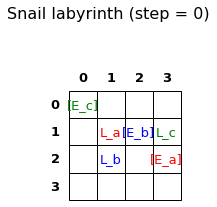

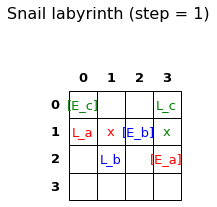

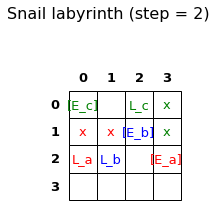

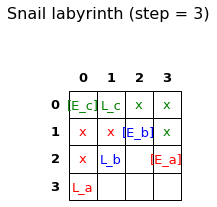

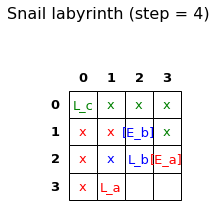

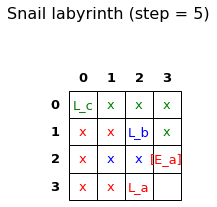

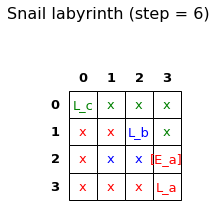

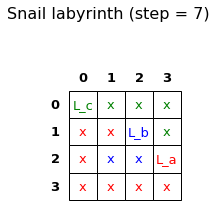

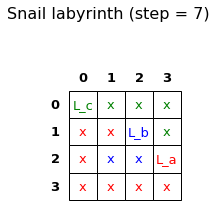

In [13]:
def solve7():
    lb = Labyrinth(4, 4,
                    [Position(2,3), Position(1,2), Position(0,0)],
                    [])
    s0 = State([Position(1,1), Position(2,1), Position(1,3)])
    s = %time lb.solve_Astar(s0)
#     print(lb.solve(s0))
    lb.print_solution(s)
#     Si vous voulez visualiser les résultats, décommenter la ligne ci-dessous.
    lb.print_labyrinth(s, show_all=True)
    
solve7()

#### Tests
Voici deux autres problèmes à résoudre : le premier doit être résolu en 9 mouvement; le second en 12.
<table><tr>
<td> <img src="https://i.imgur.com/QCf38qc.png" alt="Drawing"/> </td>
<td> <img src="https://i.imgur.com/3W4iDSk.png" alt="Drawing"/> </td>
</tr></table>

In [14]:
def solve9():
    lb = Labyrinth(5, 5,
                    [Position(3,4), Position(1,3)],
                    [])
    s0 = State([Position(2,0), Position(3,0)])
    s = %time lb.solve_Astar(s0)
    lb.print_solution(s)
#     Si vous voulez visualiser les résultats, décommenter la ligne ci-dessous.
#     lb.print_labyrinth(s, show_all=True)
    
    

def solve12():
    lb = Labyrinth(5, 7,
                [Position(0,4), Position(0,6)],
                [Position(0,3), Position(1,3), Position(2,3), Position(2,2), Position(2,4)])
    s0 = State([Position(0,0), Position(3,0)])
    s = %time lb.solve_Astar(s0)
    lb.print_solution(s)
#     Si vous voulez visualiser les résultats, décommenter la ligne ci-dessous.
#     lb.print_labyrinth(s, show_all=True)

solve9()
print("\n")
solve12()

Amount of states visited: 0
Amount of states visited: 1
Amount of states visited: 2
Amount of states visited: 3
Amount of states visited: 4
Amount of states visited: 5
Amount of states visited: 6
Amount of states visited: 7
Amount of states visited: 8
Amount of states visited: 9
Amount of states visited: 10
Amount of states visited: 11
Amount of states visited: 12
Amount of states visited: 13
Amount of states visited: 14
Amount of states visited: 15
Amount of states visited: 16
Amount of states visited: 17
Amount of states visited: 18
Amount of states visited: 19
Amount of states visited: 20
Amount of states visited: 21
Amount of states visited: 22
Amount of states visited: 23
Amount of states visited: 24
Amount of states visited: 25
Amount of states visited: 26
Amount of states visited: 27
Amount of states visited: 28
Amount of states visited: 29
Amount of states visited: 30
Amount of states visited: 31
Amount of states visited: 32
Amount of states visited: 33
Amount of states visited

Amount of states visited: 464
Amount of states visited: 465
Amount of states visited: 466
Amount of states visited: 467
Amount of states visited: 468
Amount of states visited: 469
Amount of states visited: 470
Amount of states visited: 471
Amount of states visited: 472
Amount of states visited: 473
Amount of states visited: 474
Amount of states visited: 475
Amount of states visited: 476
Amount of states visited: 477
Amount of states visited: 478
Amount of states visited: 479
Amount of states visited: 480
Amount of states visited: 481
Amount of states visited: 482
Amount of states visited: 483
Amount of states visited: 484
Amount of states visited: 485
Amount of states visited: 486
Amount of states visited: 487
Amount of states visited: 488
Amount of states visited: 489
Amount of states visited: 490
Amount of states visited: 491
Amount of states visited: 492
Amount of states visited: 493
Amount of states visited: 494
Amount of states visited: 495
Amount of states visited: 496
Amount of 

Amount of states visited: 26
Amount of states visited: 27
Amount of states visited: 28
Amount of states visited: 29
Amount of states visited: 30
Amount of states visited: 31
Amount of states visited: 32
Amount of states visited: 33
Amount of states visited: 34
Amount of states visited: 35
Amount of states visited: 36
Amount of states visited: 37
Amount of states visited: 38
Amount of states visited: 39
Amount of states visited: 40
Amount of states visited: 41
Amount of states visited: 42
Amount of states visited: 43
Amount of states visited: 44
Amount of states visited: 45
Amount of states visited: 46
Amount of states visited: 47
Amount of states visited: 48
Amount of states visited: 49
Amount of states visited: 50
Amount of states visited: 51
Amount of states visited: 52
Amount of states visited: 53
Amount of states visited: 54
Amount of states visited: 55
Amount of states visited: 56
Amount of states visited: 57
Amount of states visited: 58
Amount of states visited: 59
Amount of stat

Amount of states visited: 313
Amount of states visited: 314
Amount of states visited: 315
Amount of states visited: 316
Amount of states visited: 317
Amount of states visited: 318
Amount of states visited: 319
Amount of states visited: 320
Amount of states visited: 321
Amount of states visited: 322
Amount of states visited: 323
Amount of states visited: 324
Amount of states visited: 325
Amount of states visited: 326
Amount of states visited: 327
Amount of states visited: 328
Amount of states visited: 329
Amount of states visited: 330
Amount of states visited: 331
Amount of states visited: 332
Amount of states visited: 333
Amount of states visited: 334
Amount of states visited: 335
Amount of states visited: 336
Amount of states visited: 337
Amount of states visited: 338
Amount of states visited: 339
Amount of states visited: 340
Amount of states visited: 341
Amount of states visited: 342
Amount of states visited: 343
Amount of states visited: 344
Amount of states visited: 345
Amount of 

Amount of states visited: 645
Amount of states visited: 646
Amount of states visited: 647
Amount of states visited: 648
Amount of states visited: 649
Amount of states visited: 650
Amount of states visited: 651
Amount of states visited: 652
Amount of states visited: 653
Amount of states visited: 654
Amount of states visited: 655
Amount of states visited: 656
Amount of states visited: 657
Amount of states visited: 658
Amount of states visited: 659
Amount of states visited: 660
Amount of states visited: 661
Amount of states visited: 662
Amount of states visited: 663
Amount of states visited: 664
Amount of states visited: 665
Amount of states visited: 666
Amount of states visited: 667
Amount of states visited: 668
Amount of states visited: 669
Amount of states visited: 670
Amount of states visited: 671
Amount of states visited: 672
Amount of states visited: 673
Amount of states visited: 674
Amount of states visited: 675
Amount of states visited: 676
Amount of states visited: 677
Amount of 

Amount of states visited: 923
Amount of states visited: 924
Amount of states visited: 925
Amount of states visited: 926
Amount of states visited: 927
Amount of states visited: 928
Amount of states visited: 929
Amount of states visited: 930
Amount of states visited: 931
Amount of states visited: 932
Amount of states visited: 933
Amount of states visited: 934
Amount of states visited: 935
Amount of states visited: 936
Amount of states visited: 937
Amount of states visited: 938
Amount of states visited: 939
Amount of states visited: 940
Amount of states visited: 941
Amount of states visited: 942
Amount of states visited: 943
Amount of states visited: 944
Amount of states visited: 945
Amount of states visited: 946
Amount of states visited: 947
Amount of states visited: 948
Amount of states visited: 949
Amount of states visited: 950
Amount of states visited: 951
Amount of states visited: 952
Amount of states visited: 953
Amount of states visited: 954
Amount of states visited: 955
Amount of 

Amount of states visited: 1282
Amount of states visited: 1283
Amount of states visited: 1284
Amount of states visited: 1285
Amount of states visited: 1286
Amount of states visited: 1287
Amount of states visited: 1288
Amount of states visited: 1289
Amount of states visited: 1290
Amount of states visited: 1291
Amount of states visited: 1292
Amount of states visited: 1293
Amount of states visited: 1294
Amount of states visited: 1295
Amount of states visited: 1296
Amount of states visited: 1297
Amount of states visited: 1298
Amount of states visited: 1299
Amount of states visited: 1300
Amount of states visited: 1301
Amount of states visited: 1302
Amount of states visited: 1303
Amount of states visited: 1304
Amount of states visited: 1305
Amount of states visited: 1306
Amount of states visited: 1307
Amount of states visited: 1308
Amount of states visited: 1309
Amount of states visited: 1310
Amount of states visited: 1311
Amount of states visited: 1312
Amount of states visited: 1313
Amount o

Amount of states visited: 1606
Amount of states visited: 1607
Amount of states visited: 1608
Amount of states visited: 1609
Amount of states visited: 1610
Amount of states visited: 1611
Amount of states visited: 1612
Amount of states visited: 1613
Amount of states visited: 1614
Amount of states visited: 1615
Amount of states visited: 1616
Amount of states visited: 1617
Amount of states visited: 1618
Amount of states visited: 1619
Amount of states visited: 1620
Amount of states visited: 1621
Amount of states visited: 1622
Amount of states visited: 1623
Amount of states visited: 1624
Amount of states visited: 1625
Amount of states visited: 1626
Amount of states visited: 1627
Amount of states visited: 1628
Amount of states visited: 1629
Amount of states visited: 1630
Amount of states visited: 1631
Amount of states visited: 1632
Amount of states visited: 1633
Amount of states visited: 1634
Amount of states visited: 1635
Amount of states visited: 1636
Amount of states visited: 1637
Amount o

Amount of states visited: 1903
Amount of states visited: 1904
Amount of states visited: 1905
Amount of states visited: 1906
Amount of states visited: 1907
Amount of states visited: 1908
Amount of states visited: 1909
Amount of states visited: 1910
Amount of states visited: 1911
Amount of states visited: 1912
Amount of states visited: 1913
Amount of states visited: 1914
Amount of states visited: 1915
Amount of states visited: 1916
Amount of states visited: 1917
Amount of states visited: 1918
Amount of states visited: 1919
Amount of states visited: 1920
Amount of states visited: 1921
Amount of states visited: 1922
Amount of states visited: 1923
Amount of states visited: 1924
Amount of states visited: 1925
Amount of states visited: 1926
Amount of states visited: 1927
Amount of states visited: 1928
Amount of states visited: 1929
Amount of states visited: 1930
Amount of states visited: 1931
Amount of states visited: 1932
Amount of states visited: 1933
Amount of states visited: 1934
Amount o

Amount of states visited: 2182
Amount of states visited: 2183
Amount of states visited: 2184
Amount of states visited: 2185
Amount of states visited: 2186
Amount of states visited: 2187
Amount of states visited: 2188
Amount of states visited: 2189
Amount of states visited: 2190
Amount of states visited: 2191
Amount of states visited: 2192
Amount of states visited: 2193
Amount of states visited: 2194
Amount of states visited: 2195
Amount of states visited: 2196
Amount of states visited: 2197
Amount of states visited: 2198
Amount of states visited: 2199
Amount of states visited: 2200
Amount of states visited: 2201
Amount of states visited: 2202
Amount of states visited: 2203
Amount of states visited: 2204
Amount of states visited: 2205
Amount of states visited: 2206
Amount of states visited: 2207
Amount of states visited: 2208
Amount of states visited: 2209
Amount of states visited: 2210
Amount of states visited: 2211
Amount of states visited: 2212
Amount of states visited: 2213
Amount o

Amount of states visited: 2462
Amount of states visited: 2463
Amount of states visited: 2464
Amount of states visited: 2465
Amount of states visited: 2466
Amount of states visited: 2467
Amount of states visited: 2468
Amount of states visited: 2469
Amount of states visited: 2470
Amount of states visited: 2471
Amount of states visited: 2472
Amount of states visited: 2473
Amount of states visited: 2474
Amount of states visited: 2475
Amount of states visited: 2476
Amount of states visited: 2477
Amount of states visited: 2478
Amount of states visited: 2479
Amount of states visited: 2480
Amount of states visited: 2481
Amount of states visited: 2482
Amount of states visited: 2483
Amount of states visited: 2484
Amount of states visited: 2485
Amount of states visited: 2486
Amount of states visited: 2487
Amount of states visited: 2488
Amount of states visited: 2489
Amount of states visited: 2490
Amount of states visited: 2491
Amount of states visited: 2492
Amount of states visited: 2493
Amount o

Amount of states visited: 2771
Amount of states visited: 2772
Amount of states visited: 2773
Amount of states visited: 2774
Amount of states visited: 2775
Amount of states visited: 2776
Amount of states visited: 2777
Amount of states visited: 2778
Amount of states visited: 2779
Amount of states visited: 2780
Amount of states visited: 2781
Amount of states visited: 2782
Amount of states visited: 2783
Amount of states visited: 2784
Amount of states visited: 2785
Amount of states visited: 2786
Amount of states visited: 2787
Amount of states visited: 2788
Amount of states visited: 2789
Amount of states visited: 2790
Amount of states visited: 2791
Amount of states visited: 2792
Amount of states visited: 2793
Amount of states visited: 2794
Amount of states visited: 2795
Amount of states visited: 2796
Amount of states visited: 2797
Amount of states visited: 2798
Amount of states visited: 2799
Amount of states visited: 2800
Amount of states visited: 2801
Amount of states visited: 2802
Amount o

Amount of states visited: 3041
Amount of states visited: 3042
Amount of states visited: 3043
Amount of states visited: 3044
Amount of states visited: 3045
Amount of states visited: 3046
Amount of states visited: 3047
Amount of states visited: 3048
Amount of states visited: 3049
Amount of states visited: 3050
Amount of states visited: 3051
Amount of states visited: 3052
Amount of states visited: 3053
Amount of states visited: 3054
Amount of states visited: 3055
Amount of states visited: 3056
Amount of states visited: 3057
Amount of states visited: 3058
Amount of states visited: 3059
Amount of states visited: 3060
Amount of states visited: 3061
Amount of states visited: 3062
Amount of states visited: 3063
Amount of states visited: 3064
Amount of states visited: 3065
Amount of states visited: 3066
Amount of states visited: 3067
Amount of states visited: 3068
Amount of states visited: 3069
Amount of states visited: 3070
Amount of states visited: 3071
Amount of states visited: 3072
Amount o

Amount of states visited: 3311
Amount of states visited: 3312
Amount of states visited: 3313
Amount of states visited: 3314
Amount of states visited: 3315
Amount of states visited: 3316
Amount of states visited: 3317
Amount of states visited: 3318
Amount of states visited: 3319
Amount of states visited: 3320
Amount of states visited: 3321
Amount of states visited: 3322
Amount of states visited: 3323
Amount of states visited: 3324
Amount of states visited: 3325
Amount of states visited: 3326
Amount of states visited: 3327
Amount of states visited: 3328
Amount of states visited: 3329
Amount of states visited: 3330
Amount of states visited: 3331
Amount of states visited: 3332
Amount of states visited: 3333
Amount of states visited: 3334
Amount of states visited: 3335
Amount of states visited: 3336
Amount of states visited: 3337
Amount of states visited: 3338
Amount of states visited: 3339
Amount of states visited: 3340
Amount of states visited: 3341
Amount of states visited: 3342
Amount o

Amount of states visited: 3636
Amount of states visited: 3637
Amount of states visited: 3638
Amount of states visited: 3639
Amount of states visited: 3640
Amount of states visited: 3641
Amount of states visited: 3642
Amount of states visited: 3643
Amount of states visited: 3644
Amount of states visited: 3645
Amount of states visited: 3646
Amount of states visited: 3647
Amount of states visited: 3648
Amount of states visited: 3649
Amount of states visited: 3650
Amount of states visited: 3651
Amount of states visited: 3652
Amount of states visited: 3653
Amount of states visited: 3654
Amount of states visited: 3655
Amount of states visited: 3656
Amount of states visited: 3657
Amount of states visited: 3658
Amount of states visited: 3659
Amount of states visited: 3660
Amount of states visited: 3661
Amount of states visited: 3662
Amount of states visited: 3663
Amount of states visited: 3664
Amount of states visited: 3665
Amount of states visited: 3666
Amount of states visited: 3667
Amount o

## 4. A* algorithme (35pts)

La méthode proposée précédemment utilise une recherche en largeur pour trouver la solution. Une solution plus rapide peut être mise en place avec un algorithme `A*`. L'idée principale de l'algorithme A* est d'insérer de *l'intelligence artificielle* à la méthode de résolution. Ceci est fait en utilisant une fonction d'estimation qui permet d'évaluer la distance entre un état et la solution. 

Au lieu d'utiliser une approche *first-in first-out (premier entré, premier sorti)* lors de la visite des états, l'algorithme A* défini une valeur de priorité pour chaque état, à partir de la fonction d'estimation, et commence par visiter les états les plus prioritaires. Pour cela, on utilise une structure de données bien plus appropriée : une file de priorité.

En plus de la fonction d'estimation, A* doit aussi tenir compte d'une autre information importante : le coût actuel de l'état. Ce coût est tout simplement, dans notre cas, la distance entre l'état actuel et l'état initial. Ces deux éléments mis ensembles permettent de calculer la fonction d'estimation heuristique ***f*** d'un état `s`, comme la somme du coût actuel de l'état ***c*** et de l'estimation du coût restant ***h***. 

<center> f(s) = coût(s) + h(s) </center>

**Mise en place de l'algorithme**

- Il nous faut donc calculer le nombre de mouvements nécessaires pour atteindre l'état actuel, `coût(s)`. Pour le calculer, créez une variable `nb_moves` dans la classe `State` qui enregistre le nombre de mouvements effectués pour arriver à cet état. Cette variable commence à 0 et doit être incrémentée à chaque fois que l'on crée un nouvel état en utilisant la fonction `move(d)`.

Le coût de la fonction d'estimation est représenté par la variable `h`. Cette fonction estime le nombre de coups restants. Cette composante joue un rôle important dans l'efficacité de l'algorithme A*. Cette variable est utilisée dans la fonction `__lt__` de la classe *State*, qui compare la fonction d'estimation ` f` de deux états. 

Il est donc important de créer une bonne fonction pour résoudre le problème. Plus cette fonction est efficace, moins d'états inutiles seront visités. Cette fonction doit par contre toujours renvoyer un minorant du nombre de coups restant. On va analyser deux fonctions différentes dans ce TP.

#### Fonction 1: à partir de la distance entre les escargots et leur sortie.
- Complétez dans la classe State, la fonction ``estimee1()`` qui renvoie la distance plus grande entre les escargots et leur sortie.
- Maintenant complétez la méthode `solve_Astar(state)` pour résoudre le problème de la même façon qu'au début du TP, mais en utilisant la file de priorité à la place d'une file ordinaire.
- Modifiez les fonctions `solve_Astar(state)` et `solve(state)` de façon à compter et afficher le nombre d'états visités lors de la résolution.
- Modifiez le code des fonctions `solve7(),solve9(),solve12()` pour résoudre les problèmes à l'aide de l'algorithme A*. Vérifiez que les solutions sont obtenues en autant de mouvements qu'avec le premier algorithme, mais avec un nombre inférieur d'états visités. 

N.B: Vous pouvez ajouter des cellules pour faire le test ou afficher les resultats des algorithmes dans une même cellule. Veillez à bien identifier les résultats affichés.




## 5. Amélioration de l'heuristique (Bonus - 10pts)
Proposez une autre fonction heuristique admissible meilleure que `estimee1` pour le problème et testez-la avec les exemples fournis (`solve7()`, `solve9()` et `solve12()`). Ajoutez une fonction nommée `estimee2` et implémentez votre heuristique. **N'oubliez pas de justifier votre choix d'heuristique.**

## Barême
Partie 1: 10 points

Partie 2: 25 points

Partie 3: 30 points

Partie 4: 35 points

Partie 5: 10 points (Bonus)

Pour un total de 110 points sur 100 points.

